In [12]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [13]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from botorch.models import SaasFullyBayesianSingleTaskGP
from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from gpytorch import constraints
from botorch.models.transforms import Standardize
import math
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from torch.quasirandom import SobolEngine

In [14]:
def styblinski_tang(x):
    indices = [0, 1, 2, 3, 4]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)


# styblinski_tang関数の最適解
global_optimum = -39.16599 * 5


def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]


def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model
    

# ドロップアウトベイズクラス

In [15]:
class DropoutMixBO:
    def __init__(self, dim, active_dim, bounds, n_initial, n_iter, obj_function, dropout_prob=0.1):

        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.X = generate_initial_points(n_initial, dim, bounds)  # 初期点を生成
        self.Y = self.obj_function(self.X)  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = [self.best_f] * n_initial  # 評価履歴を初期化
        self.n_initial = n_initial
        self.n_max = n_iter
        

    def optimize(self):
        n = self.n_initial
        
        while n < self.n_max:
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims].float()  # 選んだ次元のデータだけ抽出
            train_Y = self.Y.unsqueeze(-1).float()  # Yの形状を調整
            
            model = create_model(train_X, train_Y)  # GPモデルを作成
            mll = ExactMarginalLogLikelihood(model.likelihood, model)  # 尤度関数を定義
            fit_gpytorch_model(mll)  # モデルを学習

            EI = ExpectedImprovement(model, best_f=self.best_f, maximize=False)  # Expected Improvementを定義
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).float()  # 活性化次元の探索範囲を定義
            
            candidate, _ = optimize_acqf(  # 獲得関数を最適化して次の候補点を見つける
                EI, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
            )

            x_new = torch.zeros(self.dim)  # 新しい候補点を初期化
            if np.random.random() < self.dropout_prob:  # ドロップアウトを適用するかどうか決める
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)  # 非活性化次元を特定
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))  # 非活性化次元にランダムな値を設定
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[  # 非活性化次元に最良解の値を設定
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))  # 新しい候補点での目的関数値を計算

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])  # データセットに新しい点を追加
            self.Y = torch.cat([self.Y, y_new])  # 目的関数値のリストに新しい値を追加

            if y_new < self.best_f:  # もし新しい点が今までの最良値より良ければ
                self.best_f = y_new.item()  # 最良値を更新
                self.best_x = x_new  # 最良解を更新

            self.eval_history.append(self.best_f)  # 評価履歴に現在の最良値を追加
            
            n += 1  # イテレーションを進める

        return self.best_x, self.best_f  # 最適化が終わったら最良解と最良値を返す

# ECI_B0クラス

In [16]:
class ECI_BO:
    def __init__(self, objective_function, bounds, n_initial, n_max, dim):
        self.objective_function = objective_function
        self.bounds = bounds
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = None
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        
        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]))
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        self.X = generate_initial_points(self.n_initial, self.dim, self.bounds)
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value)
            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1)
                full_x[:, i] = x.squeeze(-1)
                return -ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=5, raw_samples=20,
            )
            eci_values.append(-value.item())
        return eci_values

    def optimize(self):
        self.initialize()
        n = self.n_initial

        while n < self.n_max:
            self.update_model()
            eci_values = self.calculate_eci()
            sorted_indices = sorted(range(self.dim), key=lambda k: eci_values[k], reverse=True)

            for i in sorted_indices:
                ei = ExpectedImprovement(self.model, best_f=self.best_value)
                def eci_func(x):
                    batch_size = x.shape[0]
                    full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1)
                    full_x[:, i] = x.squeeze(-1)
                    return -ei(full_x)

                bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
                candidate, _ = optimize_acqf(
                    eci_func, bound, q=1, num_restarts=5, raw_samples=20,
                )

                new_x = self.best_point.clone()
                new_x[i] = candidate.squeeze()
                new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

                self.X = torch.cat([self.X, new_x.unsqueeze(0)])
                self.Y = torch.cat([self.Y, new_y])

                if new_y.item() < self.best_value:
                    self.best_value = new_y.item()
                    self.best_point = new_x
                    
                self.eval_history.append(self.best_value)

                n += 1
                if n >= self.n_max:
                    break

            print(f"Iteration {n}: Best value = {self.best_value}")

        return self.best_point, self.best_value

# ECI_BO_Banditクラス

In [17]:
class ECI_BO_Bandit:
    def __init__(self, objective_function, bounds, n_initial, n_max, dim):
        self.objective_function = objective_function
        self.bounds = bounds  # Should be a list of tensors: [lower_bounds, upper_bounds]
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = None
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None

        # Bandit algorithm parameters
        self.dimension_counts = [0] * self.dim  # Number of times each dimension was selected
        self.dimension_rewards = [0.0] * self.dim  # Cumulative rewards for each dimension

        self.eval_history = [self.best_value] * n_initial
        self.arm_selfction_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]))
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def normalize_rewards(self, rewards):
        min_reward = min(rewards)
        max_reward = max(rewards)
        if min_reward == max_reward:
            return [1.0] * len(rewards)
        return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

    def initialize(self):
        self.X = generate_initial_points(self.n_initial, self.dim, self.bounds)
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

        # Calculate initial ECI values and normalize them
        eci_values = self.calculate_eci()
        self.dimension_rewards = self.normalize_rewards(eci_values)

    def select_dimension(self, total_iterations):
        # UCB calculation
        ucb_values = []
        for i in range(self.dim):
            if self.dimension_counts[i] == 0:
                # Ensure each dimension is selected at least once
                return i
            average_reward = self.dimension_rewards[i] / self.dimension_counts[i]
            confidence = math.sqrt(2 * math.log(total_iterations) / self.dimension_counts[i])
            ucb = average_reward + confidence
            ucb_values.append(ucb)
        # Select dimension with highest UCB
        self.arm_selfction_history.append(ucb_values.index(max(ucb_values)))
        return ucb_values.index(max(ucb_values))

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value)

            def eci_func(x):
                # x has shape [batch_size, q=1, d=1]
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, i] = x.view(-1)
                full_x = full_x.unsqueeze(1)  # shape [batch_size, q=1, dim]
                return -ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=5, raw_samples=20,
            )
            eci_values.append(-value.item())
        return eci_values

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1  # For UCB calculation

        while n < self.n_max:
            self.update_model()

            # Select a dimension to optimize using the bandit algorithm
            selected_dim = self.select_dimension(total_iterations)

            # Optimize over the selected dimension
            ei = ExpectedImprovement(self.model, best_f=self.best_value)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, selected_dim] = x.view(-1)
                full_x = full_x.unsqueeze(1)
                return -ei(full_x)

            # Bounds for the selected dimension
            bounds = torch.tensor([
                [self.bounds[0][selected_dim]],
                [self.bounds[1][selected_dim]]
            ], device=self.X.device)

            # Optimize the acquisition function over the selected dimension
            candidate, acq_value = optimize_acqf(
                eci_func,
                bounds,
                q=1,
                num_restarts=5,
                raw_samples=20,
            )

            # Construct the new point
            new_x = self.best_point.clone()
            new_x[selected_dim] = candidate.squeeze()
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

            # Update data
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])

            # Calculate reward (improvement)
            new_rewards = [
                r + (max(self.best_value - new_y.item(), 0) if i == selected_dim else 0)
                for i, r in enumerate(self.dimension_rewards)
            ]
            self.dimension_rewards = new_rewards

            # Update best value and point if improvement is found
            if new_y.item() < self.best_value:
                self.best_value = new_y.item()
                self.best_point = new_x

            self.eval_history.append(self.best_value)

            # Update bandit statistics
            self.dimension_counts[selected_dim] += 1


            n += 1
            total_iterations += 1


        return self.best_point, self.best_value

# フルバンディットのクラス

In [18]:
class DropoutMixEST1BO:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.1, delta=0.1):
        self.dim = dim  # 全次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.delta = delta  # 信頼度
        self.X = generate_initial_points(n_initial, dim, bounds).float()  # 初期点を生成
        self.Y = self.obj_function(self.X).float()  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = [self.best_f] * n_initial  # 評価履歴を初期化
        self.improvement_history = [] # 報酬の履歴を初期化
        self.iteration = 0  # 現在のイテレーション

        # CSARアルゴリズムの初期化
        self.N = list(range(self.dim))  # 全次元の集合
        self.accepted_dims = []  # 受理された次元
        self.rejected_dims = []  # 除外された次元
        self.remaining_dims = self.N.copy()  # 残りの次元
        self.theta_hat = np.zeros(self.dim)  # 各次元の推定報酬
        self.phase = 1  # 現在のフェーズ
        self.epsilon_t = 0.5  # 初期の精度レベル
        self.delta_t = (6 / np.pi ** 2) * self.delta  # 初期の信頼度レベル
        self.m = 1

    def EST1(self, N_t, k, epsilon_t, delta_t):
        n = len(N_t)
        # N_t をサイズ 2k の部分集合に分割
        num_subsets = int(np.ceil(n / (2 * k)))
        subsets = []
        for i in range(num_subsets):
            subset = N_t[i * 2 * k:(i + 1) * 2 * k]
            if len(subset) < 2 * k:
                # 次元が足りない場合は繰り返しで埋める
                subset += subset[:(2 * k - len(subset))]
            subsets.append(subset)

        # 推定報酬と出現回数を初期化
        theta_hat = np.zeros(n)
        counts = np.zeros(n)

        # 各部分集合について推定を行う
        for subset in subsets:
            # サイズ 2k のハダマード行列を作成
            H = self.create_hadamard(2 * k)
            Z_hat = np.zeros(2 * k)

            # subset 内の次元を N_t のインデックスにマッピング
            subset_indices = [N_t.index(dim) for dim in subset]

            # ハダマード行列に従って部分集合をサンプリング
            for i in range(2 * k):
                h_row = H[i]
                if i == 0:
                    pos_dims = subset[:k]
                    neg_dims = subset[k:2 * k]
                else:
                    pos_dims = [subset[j] for j in range(2 * k) if h_row[j] == 1]
                    neg_dims = [subset[j] for j in range(2 * k) if h_row[j] == -1]

                pos_samples = []
                neg_samples = []

                for l in range(self.m):
                    # 正の次元の報酬をサンプリング
                    if len(pos_dims) > 0:
                        pos_sample = self.predict_without_x(pos_dims)
                        pos_samples.append(pos_sample)
                    else:
                        # pos_dims が空の場合、デフォルト値を使用（例として0を使用）
                        pos_samples.append(0)

                    # 負の次元の報酬をサンプリング
                    if len(neg_dims) > 0:
                        neg_sample = self.predict_without_x(neg_dims)
                        neg_samples.append(neg_sample)
                    else:
                        # neg_dims が空の場合、デフォルト値を使用（例として0を使用）
                        neg_samples.append(0)

                # 正の次元と負の次元の報酬の平均を計算
                mu_pos = np.mean(pos_samples) if len(pos_samples) > 0 else 0
                mu_neg = np.mean(neg_samples) if len(neg_samples) > 0 else 0

                if i == 0:
                    Z_hat[i] = mu_pos + mu_neg
                else:
                    Z_hat[i] = mu_pos - mu_neg

            # ハダマード行列を用いて次元ごとの報酬を推定
            theta_subset = (1 / (2 * k)) * H.T @ Z_hat

            # 推定された報酬を theta_hat に反映し、出現回数を更新
            for idx, dim_idx in enumerate(subset_indices):
                theta_hat[dim_idx] += theta_subset[idx]
                counts[dim_idx] += 1

        # 各次元の推定報酬の平均を計算
        theta_hat = theta_hat / counts

        return theta_hat

    def create_hadamard(self, n):
        # サイズnのハダマード行列を作成（nは2の累乗）
        assert n & (n - 1) == 0, "ハダマード行列のサイズは2の累乗である必要があります"
        H = np.array([[1]])
        while H.shape[0] < n:
            H = np.block([[H, H], [H, -H]])
        return H

    def predict(self, X, active_dims):
        # GPモデルを使用して予測を行う
        train_X = self.X[:, active_dims].float()
        train_Y = self.Y.unsqueeze(-1).float()
        model = create_model(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
        model.eval()
        self.iteration += 1
        print(self.iteration)
        with torch.no_grad():
            y_pred = model(X.float()).mean.item()
        return y_pred

    def predict_without_x(self, active_dims):
        # GPモデルを使用して予測を行う
        train_X = self.X[:, active_dims].float()
        train_Y = self.Y.unsqueeze(-1).float()
        model = create_model(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)
        model.eval()
        self.iteration += 1
        print(self.iteration)

        # Expected Improvement (EI) 獲得関数の定義
        EI = ExpectedImprovement(model, best_f=self.best_f, maximize=False)
        bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).float()

        # 獲得関数の最適化
        candidate, _ = optimize_acqf(
            EI, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
            options={"maxiter": 200, "batch_limit": 5}
        )

        # 新しい候補点を構築
        x_new = torch.zeros(self.dim, dtype=torch.float32)
        x_new[active_dims] = candidate.squeeze()
        x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
            np.setdiff1d(range(self.dim), active_dims)]

        with torch.no_grad():
            y_pred = model(x_new[active_dims].unsqueeze(0).float()).mean.item()
        return y_pred

        # 目的関数の評価
        y_new = self.obj_function(x_new.unsqueeze(0))
        if isinstance(y_new, torch.Tensor):
            y_new = y_new.item()

        improvement = np.exp(-((y_pred - y_new) ** 2))
        self.improvement_history.append(improvement)

        # 活性化次元の推定報酬を更新
        for dim in active_dims:
            self.theta_hat[dim] = (self.theta_hat[dim] + improvement) / 2  # 平均を取る

        # データセットに新しい点を追加
        self.X = torch.cat([self.X, x_new.unsqueeze(0)])
        self.Y = torch.cat([self.Y, y_new])

        # 最良の解を更新
        if y_new < self.best_f:
            self.best_f = y_new.item()
            self.best_x = x_new

        self.eval_history.append(self.best_f)

        return improvement

    def optimize(self, n_iter):
        while self.iteration < n_iter:
            # CSARアルゴリズムの実行
            while len(self.remaining_dims) + len(self.accepted_dims) > self.active_dim:
                # 推定アルゴリズムEST1を使用して報酬を推定
                theta_hat_t = self.EST1(self.remaining_dims, self.active_dim, self.epsilon_t, self.delta_t)
                # 推定報酬に基づいて次元をソート
                sorted_indices = np.argsort(-theta_hat_t)
                sorted_dims = [self.remaining_dims[i] for i in sorted_indices]

                # 受理および除外する次元を決定
                theta_k = theta_hat_t[sorted_indices[self.active_dim - 1]]
                theta_k_plus_1 = theta_hat_t[sorted_indices[self.active_dim]] if len(sorted_dims) > self.active_dim else -np.inf

                # A = [sorted_dims[i] for i in range(len(sorted_dims)) if theta_hat_t[sorted_indices[i]] - theta_k_plus_1 > 2 * self.epsilon_t]
                # R = [sorted_dims[i] for i in range(len(sorted_dims)) if theta_k - theta_hat_t[sorted_indices[i]] > 2 * self.epsilon_t]

                # m = 1 のときのepsilon_t
                epsilon_m = np.sqrt(2 / self.m * np.log(len(self.remaining_dims) / self.delta_t) )

                A = []
                R = [sorted_dims[i] for i in range(len(sorted_dims)) if theta_k - theta_hat_t[sorted_indices[i]] > 2 * epsilon_m]

                #self.accepted_dims.extend(A)
                self.rejected_dims.extend(R)
                self.remaining_dims = [dim for dim in self.remaining_dims if dim not in A and dim not in R]

                # 精度と信頼度を更新
                self.phase += 1
                self.m += 1
                self.epsilon_t /= 2
                self.delta_t = (6 / (np.pi ** 2)) * (self.delta / (self.phase ** 2))

                # 必要な次元数が揃ったらループを抜ける
                if len(self.accepted_dims) >= self.active_dim:
                    break

            # 活性化次元を決定
            if len(self.accepted_dims) >= self.active_dim:
                active_dims = self.accepted_dims[:self.active_dim]
            else:
                active_dims = self.accepted_dims + self.remaining_dims[:(self.active_dim - len(self.accepted_dims))]

            active_dims = active_dims[:self.active_dim]  # 必要に応じて調整

            # 次のイテレーションのためにリセット
            self.remaining_dims = self.N.copy()
            self.accepted_dims = []
            self.rejected_dims = []
            self.phase = 1
            self.epsilon_t = 0.5
            self.delta_t = (6 / np.pi ** 2) * self.delta

        return self.best_x, self.best_f

# 最適化

In [19]:
dim = 100
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 300

In [20]:
dropout_bo_copy = DropoutMixBO(dim, active_dim, bounds, n_initial, n_iter, styblinski_tang, dropout_prob=0.0)
eci_bo = ECI_BO(styblinski_tang, bounds, n_initial, n_iter, dim)
eci_bo_bandit = ECI_BO_Bandit(styblinski_tang, bounds, n_initial, n_iter, dim)
full_bandit = DropoutMixEST1BO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)

In [21]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      #best_x_dropout, best_f_dropout = dropout_bo_copy.optimize()
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize()
      pbar.update(20)
      #best_x, best_f = eci_bo.optimize()
      pbar.update(10)
      best_x_bandit, best_f_bandit = eci_bo_bandit.optimize()
      pbar.update(10)
      #dropout_bandit_est1_best_x, dropout_bandit_est1_best_f = full_bandit.optimize(n_iter)
      pbar.update(20) 
      pbar.update(10)
      pbar.update(10)
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

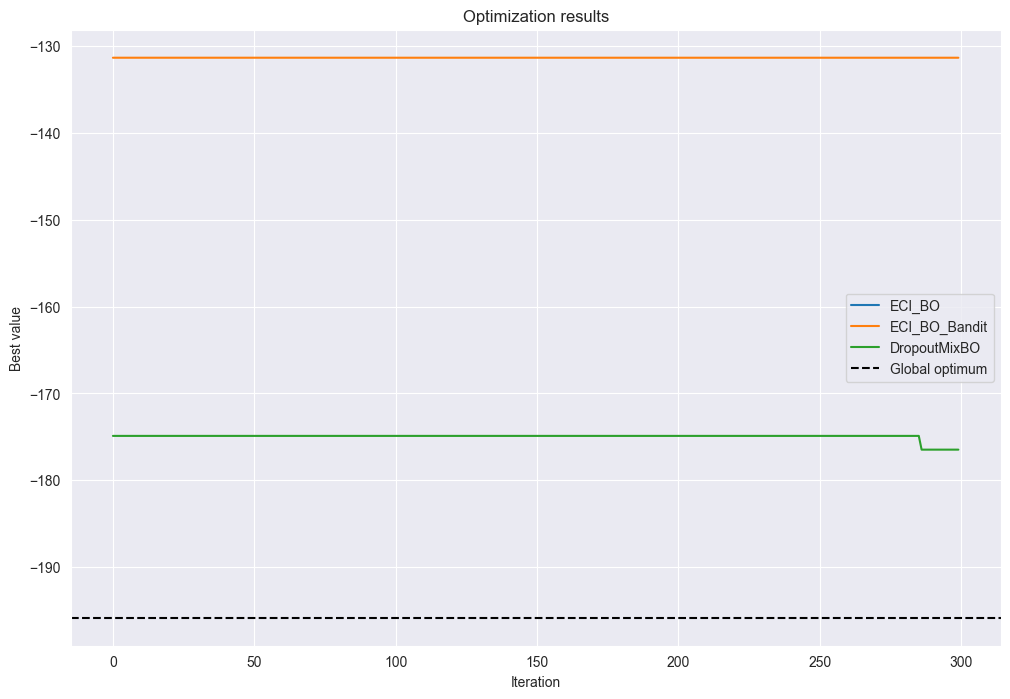

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(eci_bo.eval_history, label="ECI_BO")
plt.plot(eci_bo_bandit.eval_history, label="ECI_BO_Bandit")
plt.plot(dropout_bo_copy.eval_history, label="DropoutMixBO")
#plt.plot(full_bandit.eval_history, label="fullBandit")
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum")
plt.xlabel("Iteration")
plt.ylabel("Best value")
plt.title("Optimization results")
plt.legend()
plt.grid(True)
plt.show()
